# BKT Model #3

See BKT 1 for details on terminology and variables. This model will be a variation of the baseline model by also adding student-specific $p(L_0)$ parameters using gradients and such

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import sklearn
from sklearn import metrics
import sys
sys.path.append('../')
from cf_matrix import make_confusion_matrix

## Loading data

In [2]:
# load data
data_dir = '../data/'

start = time.time()
df_train = pd.read_csv(data_dir + 'df_train2.0.csv')
print('Training Data Loaded, time elapsed:', round(time.time() - start, 3), 'seconds')
# not using - df_lectures = pd.read_csv(data_dir + 'lectures.csv')
df_questions = pd.read_csv(data_dir + 'questions.csv')
df_test = pd.read_csv(data_dir + 'df_test2.0.csv')

print('All Dataframes Loaded ------------------------------')

Training Data Loaded, time elapsed: 52.508 seconds
All Dataframes Loaded ------------------------------


### Viewing/cleaning

In [3]:
df_train.drop('Unnamed: 0', axis=1, inplace=True)
df_test.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
df_train

,timestamp,user_id,content_id,user_answer,answered_correctly
0,0,115,5692,3,1
1,56943,115,5716,2,1
2,118363,115,128,0,1
3,131167,115,7860,0,1
4,137965,115,7922,1,1
...,...,...,...,...,...
98287376,428466169,2147482888,5591,3,1
98287377,428517313,2147482888,6128,1,1
98287378,428542872,2147482888,6202,2,1
98287379,428564420,2147482888,3586,0,1


In [5]:
df_test

,timestamp,user_id,content_id,user_answer,answered_correctly
0,668090043,115,3363,1,0
1,668090043,115,3365,0,0
2,668090043,115,3364,1,1
3,571323,124,7218,3,0
4,571323,124,7216,0,0
...,...,...,...,...,...
983914,1470571968,2147482216,1177,3,1
983915,1470594073,2147482216,1399,1,1
983916,428613475,2147482888,4212,3,1
983917,428649406,2147482888,6343,1,0


In [6]:
# dropping bundle_id and part from questions
# bundle_id represents which questions are shown together and may be used for future modifications of the model,
#  but different bundles don't seem to correspond to different tags so I won't use them here
# part corresponds to a higher level type of question ranging rom 1-5 that are too broad for this analysis
dropcols = ['bundle_id', 'part']
df_questions.drop(dropcols, axis=1, inplace=True)

# changing 'tags' column to a list structure so its easier to query later on and setting null value to -1
df_questions['tags'].fillna('-1', inplace=True)
df_questions['tags'] = df_questions['tags'].str.split()

In [7]:
df_questions

,question_id,correct_answer,tags
0,0,0,"[51, 131, 162, 38]"
1,1,1,"[131, 36, 81]"
2,2,0,"[131, 101, 162, 92]"
3,3,0,"[131, 149, 162, 29]"
4,4,3,"[131, 5, 162, 38]"
...,...,...,...
13518,13518,3,[14]
13519,13519,3,[8]
13520,13520,2,[73]
13521,13521,0,[125]


## Skill-specific parameters

I'll use the same skill parameters as in BKT 1 and 2, but the p_init and p_transits will only be used for initial viewing of a skill, and then student-specific parameters will be used and updated during training

In [8]:
f = open('../data/skill_params.json')
params = json.load(f)

In [9]:
df_params = pd.DataFrame(params).T
df_params.drop('-1', inplace=True)
df_params

,p_init,p_transit,p_guess,p_slip
131,0.721816,0.266157,0.283920,0.173870
93,0.770456,0.510148,0.149957,0.089715
81,0.549010,0.148939,0.358141,0.262111
10,0.327621,0.255193,0.227717,0.224273
94,0.377834,0.358519,0.122535,0.153673
...,...,...,...,...
139,0.631673,0.402746,0.257155,0.125458
11,0.258517,0.241626,0.223282,0.216444
59,0.443121,0.360506,0.235307,0.165463
86,0.572785,0.616438,0.008499,0.005906


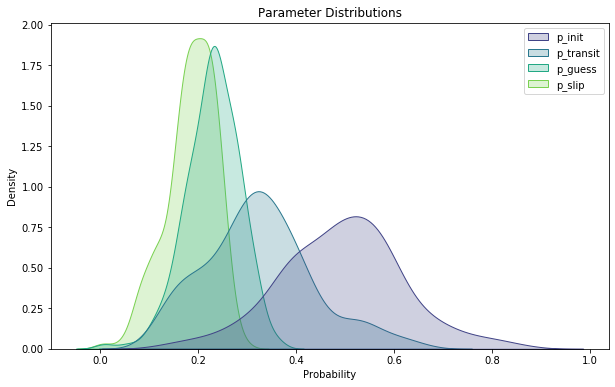

In [10]:
# cool viz again
plt.figure(figsize=(10,6))
sns.kdeplot(data=df_params, fill=True, palette='viridis')
plt.xlabel('Probability')
plt.title('Parameter Distributions')
plt.show()

### How well do these parameters (mainly p_init) predict actual student's prior knowledge?

In [19]:
skills_sorted = list(df_params.sort_values(by='p_init').index)

In [163]:
rand_user = df_train[df_train['user_id'] == list(df_train['user_id'].unique())[np.random.randint(len(df_train['user_id'].unique()))]]

In [164]:
df_merged = pd.merge(rand_user, df_questions, left_on='content_id', right_on='question_id')
df_merged

,timestamp,user_id,content_id,user_answer,answered_correctly,question_id,correct_answer,tags
0,0,748953371,7900,0,1,7900,0,"[131, 93, 81]"
1,29260,748953371,7876,3,1,7876,3,"[10, 94, 92]"
2,53449,748953371,175,2,1,175,2,"[9, 10, 92]"
3,77278,748953371,1278,3,1,1278,3,"[143, 140, 81, 29]"
4,187125,748953371,2065,2,1,2065,2,"[136, 162, 92, 29]"
5,187125,748953371,2064,0,0,2064,1,"[157, 92, 29]"
6,187125,748953371,2063,1,0,2063,0,"[136, 92, 29]"
7,258438,748953371,3365,1,0,3365,2,"[136, 103, 29]"
8,258438,748953371,3364,1,1,3364,1,"[136, 103, 29]"
9,258438,748953371,3363,2,0,3363,3,"[74, 103, 29]"


How to get student-specific p_init?

* one p_init per skill is probably best
* p_init can be defined as their performance on first seeing the skill
    * issues with this can be prior knowledge for skills not seen before during testing
    * can always start at 0 in this case
* another option is to incorporate skill correlations (below)
    * eliminates uncertainty about skills not seen before

In [121]:
def p_init_firstonly(df):
    """
    Uses only the correctness of the first encounter to a skill
    Takes merged df as parameter
    """
    p_inits = dict()
    for i,row in df.iterrows():
        if row['user_id'] not in p_inits.keys():
            p_inits[row['user_id']] = dict()
        for tag in row['tags']:
            if tag in p_inits[row['user_id']].keys():
                continue
            p_inits[row['user_id']][tag] = row['answered_correctly']
    return p_inits

In [120]:
def p_init_averaged(df):
    """
    Takes average correctness for each skill
    """
    print('COMPUTING AVERAGES')
    start = time.time()
    p_inits = dict()
    sequences = dict()
    for i,row in df.iterrows():
        if row['user_id'] not in p_inits.keys():
            p_inits[row['user_id']] = dict()
            sequences[row['user_id']] = dict()
        for tag in row['tags']:
            if tag not in sequences[row['user_id']].keys():
                sequences[row['user_id']][tag] = []
            sequences[row['user_id']][tag].append(row['answered_correctly'])
        if i % 1000000 == 0:
            print('ITERATION {} DONE ----- TIME ELAPSED: {} SECONDS'.format(i, time.time() - start))
            start = time.time()
    
    for user,tags in sequences.items():

        for tag,seq in tags.items():
            p_inits[user][tag] = sum(seq) / (len(seq) )
        
        for i in range(188):
            if str(i) not in p_inits[user].keys():
                p_inits[user][str(i)] = .05
#             if p_inits[user][str(i)] == 1:
#                 p_inits[user][str(i)] = 0.7
    
    return p_inits

In [97]:
def p_init_corrs(df_merged, skill_corrs):
    """
    Adjusts p_inits so that correlated skills are weighted by each other
    uses avg first
    updates with rule given p_init p and correlated skill q: (p * q) / (p*q + (1-p * 1-q))
    """
    p_inits = p_init_averaged(df_merged)
    print('AVERAGES COMPUTED ------ ADJUSTING SKILL CORRELATIONS')
    for i in range(188): # go through all 
        for user in p_inits.keys():
            val = p_inits[user][str(i)]
            if val == 0:
                tot = 0
                totvals = 0
                for tag in np.argsort(skill_corrs[i]):
                    if skill_corrs[i][tag] != 0:
                        tot += 1
                        totvals += p_inits[user][str(tag)]
                p_inits[user][str(i)] = totvals / tot
            else:
                for tag in np.argsort(skill_corrs[i]):
                    if skill_corrs[i][tag] != 0:
                        if p_inits[user][str(tag)] != 0:
                            corval = p_inits[user][str(tag)]
                            p_inits[user][str(i)] = (val * corval) / ((val * corval) + ((1-val)*(1-corval)))
    return p_inits
                        

$$\frac{pq}{pq + ((1-p)(1-q))}$$

In [20]:
p_init_c = p_init_corrs(df_train_merged, skill_corrs)

{2273870: {'131': 1.0, '93': 1.0, '81': 0.7962962962962963, '10': 0.3333333333333333, '94': 0.0, '92': 0.7363636363636363, '9': 0.5, '143': 0.8059701492537313, '140': 0.8823529411764706, '29': 0.7230769230769231, '157': 1.0, '136': 0.5, '162': 0.7916666666666666, '103': 0.4166666666666667, '74': 0.3333333333333333, '67': 0.3333333333333333, '82': 0.0, '102': 0.7121212121212122, '161': 0.5, '80': 0.8333333333333334, '123': 0.6, '133': 0.8333333333333334, '23': 0.3333333333333333, '151': 0.5, '79': 0.6666666666666666, '115': 0.5, '27': 0.5, '91': 0.5, '1': 0.7777777777777778, '97': 1.0, '50': 0.5, '21': 0.5, '118': 0.0, '19': 0.0, '18': 1.0, '69': 0.7857142857142857, '2': 0.8095238095238095, '107': 0.8235294117647058, '62': 0.8157894736842105, '38': 0.8181818181818182, '155': 0.6666666666666666, '119': 0.6153846153846154, '137': 0.9047619047619048, '142': 1.0, '138': 0.8, '41': 0.7272727272727273, '90': 0.5555555555555556, '100': 0.6, '177': 1.0, '112': 1.0, '57': 0.5, '173': 1.0, '159':

**Not going to use the correlations of skill parameters here** jk i am

In [74]:
skill_corrs = np.zeros((188,188))
for x in range(188):
    if x % 10 == 0:
        print(x)
    for y in range(188):
        y_count = df_questions['tags'].apply(lambda i : str(y) in i).sum()
        xy_count = df_questions['tags'].apply(lambda i : str(y) in i and str(x) in i).sum()
        skill_corrs[x][y] = (xy_count / y_count) * (y_count / len(df_questions))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180


In [77]:
np.savetxt('skill_corrs.txt', skill_corrs)

In [13]:
skill_corrs = np.loadtxt('skill_corrs.txt')

## Training

In [55]:
class BKTModel: # with student-specific p_inits
    
    def __init__(self, skill_params, q_tags, p_inits, skill_corrs):
        self.skill_params = skill_params
        self.users = dict() # form: {user_id : {skill: .1, skill2: .9, etc}}
        self.questions = q_tags
        self.p_init = p_inits
        self.skill_corrs = skill_corrs
    
    # eq 1
    def get_prior(self, user, skill):
        if skill in self.p_init[user].keys() and self.p_init[user][skill] != 0.:
            return self.p_init[user][skill]
        else:
            val = self.skill_params[skill]['p_init']
            for tag in np.argsort(self.skill_corrs[int(skill)])[:-10]:
                if self.skill_corrs[int(skill)][tag] != 0:
                    if str(tag) in self.users[user].keys():
                        corval = self.users[user][str(tag)]
                        val = (val * corval) / ((val * corval) + ((1 - val) * (1 - corval)))
            return val
                
    
    def get_user_skill(self, user, skill):
        """
        Gets the p(L) of a user for given skill, initializes the user/skill if not already in self.users
        """
        if user not in self.users.keys():
            self.users[user] = dict()
        if skill not in self.users[user]:
            self.users[user][skill] = self.get_prior(user, skill)
        return self.users[user][skill]
    
    def train(self, df):
        """
        To train the model 
        
        parameters
        ----------
        df : pandas dataframe of training data where each row corresponds to an event/observation
        """
        # helper functions corresponding to above equations
        # eq 2
        def cond_correct(user, skill):
            pL = self.get_user_skill(user, skill)
            top = pL * (1 - self.skill_params[skill]['p_slip'])
            bottom = top + ((1 - pL) * self.skill_params[skill]['p_guess'])
            return top / bottom
        # eq 3
        def cond_wrong(user, skill):
            pL = self.get_user_skill(user, skill)
            top = pL * self.skill_params[skill]['p_slip']
            bottom = top + ((1 - pL) * (1 - self.skill_params[skill]['p_guess']))
            return top / bottom
        # eq 4, calls 2 or 3
        # 'correct' is bool (0=false/1=true)
        def update_knowledge(user, skill, correct):
            if correct:
                cond_pL = cond_correct(user, skill)
            else:
                cond_pL = cond_wrong(user, skill)
            self.users[user][skill] = cond_pL + ((1 - cond_pL) * self.skill_params[skill]['p_transit'])
            
        # main training loop
        print('BEGINNING TRAINING --------------------------------------------------------------')
        start = time.time()
        for i,row in df.iterrows():
            tags = self.questions[row['content_id']]
            for tag in tags:
                if tag == '-1':
                    continue
                update_knowledge(row['user_id'], tag, row['answered_correctly'])
            
            if i % 1000000 == 0:
                print('Iteration {} done -------------------- Time elapsed: {} seconds'.format(i, time.time() - start))
                start = time.time()
                
    # eq 5
    def predict(self, user, skill):
        """
        Function to predict correctness of a single user to answering a question within a skill
        """
        pL = self.get_user_skill(user, skill)
        return (pL * (1 - self.skill_params[skill]['p_slip'])) + ((1 - pL) * self.skill_params[skill]['p_guess'])
    
    def test(self, df, cutoff, confusion_mat=True, raw_probs=True):
        """
        Function to run predictions on testing data. 
        If a question has multiple tags then I take the average of those predictions
        
        parameters
        ----------
        df : pandas dataframe with testing data, must be in format where 1 row = 1 observation
        cutoff : cutoff probability to be marked as correct (ie if 0.5 then everything >= 0.5 = correct)
        confusion_mat : whether to return a confusion matrix plot, default True
        raw_probs : whether to return the raw probabilities (before casting to 0/1 based on cutoff), default True
        
        returns
        --------
        df_test : test dataframe with predicted correct/incorrect column
                    also includes raw_probability column if param is True
        accuracy : computed accuracy
        confusion : confusion matrix visualization
        """
        
        predicted = []
        raw_probability = []
        for i,row in df.iterrows():
            tags = self.questions[row['content_id']]
            tot = 0
            for tag in tags:
                tot += self.predict(row['user_id'], tag)
            raw_probability.append(tot / len(tags))
            predicted.append(int((tot/len(tags)) > cutoff))
        
        df_test = df.copy()
        df_test['predicted'] = predicted
        if raw_probs:
            df_test['raw_probability'] = raw_probability
        accuracy = sklearn.metrics.accuracy_score(df_test['answered_correctly'].values, predicted)
        
        if confusion_mat:
            confusion = sklearn.metrics.confusion_matrix(df_test['answered_correctly'].values, predicted)
            categories = ['incorrect', 'correct']
            confusion_viz = make_confusion_matrix(confusion, categories=categories)
            return df_test, accuracy, confusion_viz
        return df_test, accuracy

In [460]:
df_train_merged = pd.merge(df_train, df_questions, left_on='content_id', right_on='question_id')

In [ ]:
q_tags = dict(zip(df_questions['question_id'], df_questions['tags']))
p_init_c = p_init_corrs(df_train_merged, skill_corrs)
BKT = BKTModel(params, q_tags, p_init_c, skill_corrs)

COMPUTING AVERAGES


In [ ]:
BKT.train(df_train)

In [26]:
BKT.users = {str(k):v for k,v in BKT.users.items()}

with open('users_trained.json','w') as json_file:
    json.dump(BKT.users, json_file)

In [ ]:
f = open('users_trained.json')
BKT.users = json.load(f)
f.close()

## Testing

In [27]:
df_test

,timestamp,user_id,content_id,user_answer,answered_correctly
0,668090043,115,3363,1,0
1,668090043,115,3365,0,0
2,668090043,115,3364,1,1
3,571323,124,7218,3,0
4,571323,124,7216,0,0
...,...,...,...,...,...
983914,1470571968,2147482216,1177,3,1
983915,1470594073,2147482216,1399,1,1
983916,428613475,2147482888,4212,3,1
983917,428649406,2147482888,6343,1,0


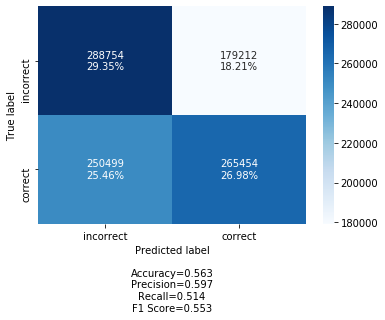

In [28]:
df_results, acc, confusion = BKT.test(df_test, cutoff=0.5)

## Debugging with mini training sets

In [15]:
q_tags = dict(zip(df_questions['question_id'], df_questions['tags']))

In [143]:
unique_users = df_train['user_id'].unique()
users_small = [unique_users[i] for i in np.random.randint(len(unique_users), size=500)]

In [144]:
df_train_small = df_train[df_train['user_id'].isin(users_small)]
df_test_small = df_test[df_test['user_id'].isin(users_small)]
df_train_merged = pd.merge(df_train_small, df_questions, left_on='content_id', right_on='question_id')
df_train_merged

,timestamp,user_id,content_id,user_answer,answered_correctly,question_id,correct_answer,tags
0,0,15471228,7900,0,1,7900,0,"[131, 93, 81]"
1,0,43758492,7900,0,1,7900,0,"[131, 93, 81]"
2,0,68563254,7900,2,0,7900,0,"[131, 93, 81]"
3,0,68573983,7900,0,1,7900,0,"[131, 93, 81]"
4,0,86423618,7900,0,1,7900,0,"[131, 93, 81]"
...,...,...,...,...,...,...,...,...
127796,44962270752,2075690358,7436,2,1,7436,2,"[97, 37, 21]"
127797,46110971774,2075690358,12492,1,1,12492,1,"[74, 12, 38]"
127798,46110971774,2075690358,12494,3,1,12494,3,"[161, 12, 38]"
127799,46110971774,2075690358,12493,1,1,12493,1,"[136, 12, 38]"


In [145]:
#p_init_avg = p_init_averaged(df_train_merged)
p_init_c = p_init_corrs(df_train_merged, skill_corrs)

COMPUTING AVERAGES
ITERATION 0 DONE ----- TIME ELAPSED: 0.060929059982299805 SECONDS
AVERAGES COMPUTED ------ ADJUSTING SKILL CORRELATIONS


In [146]:
BKT_debug2 = BKTModel(params, q_tags, p_init_c, skill_corrs)
BKT_debug2.train(df_train_small)

BEGINNING TRAINING --------------------------------------------------------------


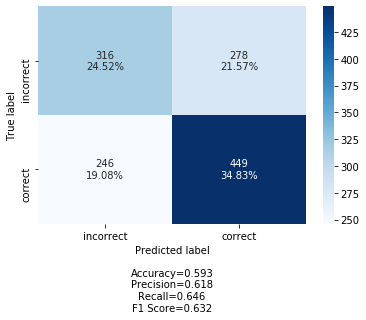

In [147]:
df_results_debug, acc_, _ = BKT_debug2.test(df_test_small, cutoff=0.5)

In [148]:
sklearn.metrics.roc_auc_score(df_results_debug['answered_correctly'], df_results_debug['predicted'])

0.589014848727079

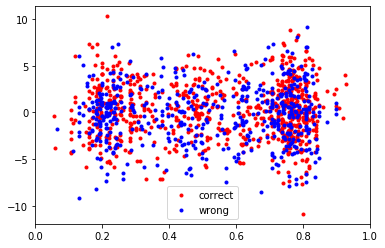

In [149]:
# pred correct/incorrect distributions
pred_correct = df_results_debug[df_results_debug['answered_correctly'] == df_results_debug['predicted']]
pred_wrong = df_results_debug[df_results_debug['answered_correctly'] != df_results_debug['predicted']]

plt.scatter(pred_correct['raw_probability'].values, np.random.normal(0,3,len(pred_correct)), marker='.', color='r', label='correct')
plt.scatter(pred_wrong['raw_probability'].values, np.random.normal(0,3,len(pred_wrong)), marker='.', color='b', label='wrong')
plt.legend()
plt.xlim(0,1)
plt.show()

<Figure size 1440x1080 with 0 Axes>

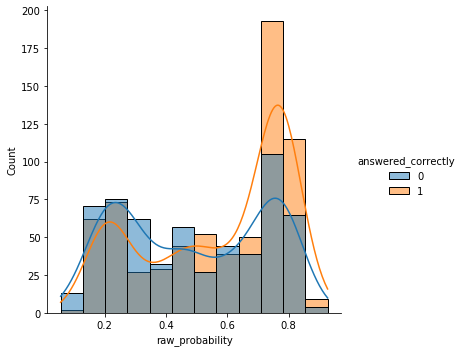

In [150]:
plt.figure(figsize=(20,15))
sns.displot(data=df_results_debug, x='raw_probability', hue='answered_correctly', kde=True)
plt.show()